In [1]:
import time
import math

import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import skimage.io
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# https://stackoverflow.com/questions/42286426/what-is-the-difference-between-xavier-initializer-and-xavier-initializer-conv2d
# itializer is designed to keep the scale of the gradients roughly the same in all layers
from tensorflow.contrib.layers import xavier_initializer_conv2d
from tensorflow.contrib.layers import xavier_initializer


Instructions for updating:
Use the retry module or similar alternatives.


# Task 3 - Tensorflow MNIST

Define and train a tensorflow model which is equivalent to the regularized model from Task 2. Define an identical architecture and training parameters in order to reproduce the results. Use the convolution operations from `tf.nn.conv2d` or `tf.contrib.layers.convolution2d`. Study the official documentation for the [convolution](https://www.tensorflow.org/versions/master/api_docs/python/nn.html#convolution) suport in Tensorflow. Visualize the trained filters from the first layer during training, as in Task 2.

An example of using convolutions defined in the `tf.contrib` package is shown below. If you prefer to use `tf.nn.conv2d`, please consult the official [tutorial](https://www.tensorflow.org/versions/master/tutorials/mnist/pros/index.html#build-a-multilayer-convolutional-network).

In [ ]:
### don't run!
import tensorflow.contrib.layers as layers

def build_model(inputs, labels, num_classes):
    weight_decay = ...
    conv1sz = ...
    fc3sz = ...
    with tf.contrib.framework.arg_scope([layers.convolution2d],
            kernel_size=5, stride=1, padding='SAME', activation_fn=tf.nn.relu,
            weights_initializer=layers.variance_scaling_initializer(),
            weights_regularizer=layers.l2_regularizer(weight_decay)):

        net = layers.convolution2d(inputs, conv1sz, scope='conv1')
        # ostatak konvolucijskih i pooling slojeva
        ...

    with tf.contrib.framework.arg_scope([layers.fully_connected],
            activation_fn=tf.nn.relu,
            weights_initializer=layers.variance_scaling_initializer(),
            weights_regularizer=layers.l2_regularizer(weight_decay)):

        # sada definiramo potpuno povezane slojeve
        # ali najprije prebacimo 4D tenzor u matricu
        net = layers.flatten(inputs)
        net = layers.fully_connected(net, fc3sz, scope='fc3')

    logits = layers.fully_connected(net, num_classes, activation_fn=None, scope='logits')
    loss = ...

    return logits, loss


In [16]:
DATA_DIR = 'MNIST original'
SAVE_DIR = 'task3_out'
import os
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

config = {}
config['max_epochs'] = 8
config['batch_size'] = 50
config['save_dir'] = SAVE_DIR
config['weight_decay'] = 1e-3
config['lr_policy'] = {1:{'lr':1e-1}, 3:{'lr':1e-2}, 5:{'lr':1e-3}, 7:{'lr':1e-4}}


In [17]:
#np.random.seed(100) 
np.random.seed(int(time.time() * 1e6) % 2**31)
dataset = input_data.read_data_sets(DATA_DIR, one_hot=True)
train_x = dataset.train.images
train_x = train_x.reshape([-1, 28, 28, 1])
train_y = dataset.train.labels

valid_x = dataset.validation.images
valid_x = valid_x.reshape([-1, 28, 28, 1])
valid_y = dataset.validation.labels

test_x = dataset.test.images
test_x = test_x.reshape([-1, 28, 28, 1])
test_y = dataset.test.labels

train_mean = train_x.mean()
train_x -= train_mean
valid_x -= train_mean
test_x -= train_mean


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST original\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST original\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST original\t10k-images-idx3-ubyte.gz
Extracting MNIST original\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [20]:

##
# Dimensions of tensor are: [batch, height, width, channels]
##


def Convolution(_input, w, b, n_strides=1):
    # strides determines how much the window shifts by in each of the dimensions.
    # The typical use sets the first (the batch) and last (the depth) stride to 1.
    node = tf.nn.conv2d(_input, w, strides=[1, n_strides, n_strides, 1], padding='SAME')
    node = tf.nn.bias_add(node, b)
    return node


def ReLU(_input):
    return tf.nn.relu(_input)


def MaxPooling(_input, ks=2, n_strides=2):
    # https://stackoverflow.com/questions/38601452/the-usages-of-ksize-in-tf-nn-max-pool
    # ksize - kernel size. eg. [1,2,2,1] - kernel 2x2
    
    # strides - determines how much the window shifts by in each of the dimensions.
    # The typical use sets the first (the batch) and last (the depth) stride to 1.
    
    # https://stackoverflow.com/questions/34642595/tensorflow-strides-argument
    # The input to the convolution has shape=[1, 32, 32, 1].
    # If you specify strides=[1,1,1,1] with padding=SAME, then the output of the filter will be [1, 32, 32, 8].
    return tf.nn.max_pool(_input, ksize=[1, ks, ks, 1], strides=[1, n_strides, n_strides, 1], padding='SAME')


def Flatten(_input, w):
    # Given tensor, this operation returns a tensor that has the same values as tensor with shape shape.
    # this is needed because fully connected layer is simple "1-d vector"
    return tf.reshape(_input, [-1, w.shape[0]])


def FC(_input, w, b):
    return tf.matmul(_input, w) + b


def SoftmaxCrossEntropyWithLogits(logits, labels):
    # softmax_cross_entropy_with_logits_v2 is new version of deprecated softmax_cross_entropy_with_logits
    # https://stats.stackexchange.com/questions/327348/how-is-softmax-cross-entropy-with-logits-different-from-softmax-cross-entropy-wi
    # "in supervised learning one doesn't need to backpropagate to labels"
    # thats why tf.stop_gradient in softmax_cross_entropy_with_logits_v2
    return tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=tf.stop_gradient(labels))


def ReduceMean(_input):
    return tf.reduce_mean(_input)


def RegularizedLoss(loss, regularizers):
    return loss + config['weight_decay']*regularizers


def L2Regularizer(weights):
    return tf.nn.l2_loss(weights)
    

In [21]:
n_classes = dataset.train.labels.shape[1] # [0] - num of labels, [1] - num of classes


tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Yoh_ = tf.placeholder(tf.float32, [None, n_classes])

net=X
regularizers=0
#net = tf.reshape(X, shape=[-1, 28, 28, 1])

w_conv1 = tf.get_variable('w_conv1', [5, 5, 1, 16], initializer=xavier_initializer_conv2d())
b_conv1 = tf.Variable(tf.zeros([16]), name='b_conv1')
net = Convolution(net, w_conv1, b_conv1)
regularizers += L2Regularizer(w_conv1)
net = MaxPooling(net)
net = ReLU(net)

w_conv2 = tf.get_variable('w_conv2', [5, 5, 16, 32], initializer=xavier_initializer_conv2d())
b_conv2 = tf.Variable(tf.zeros([32]), name='b_conv2')
net = Convolution(net, w_conv2, b_conv2)
regularizers += L2Regularizer(w_conv2)
net = MaxPooling(net)
net = ReLU(net)

## 7x7
w_fc3 = tf.get_variable('w_fc3', [7*7*32, 512], initializer=xavier_initializer())
b_fc3 = tf.Variable(tf.zeros([512]), name='b_fc3')
net = Flatten(net, w_fc3)
net = FC(net, w_fc3, b_fc3)
regularizers += L2Regularizer(w_fc3)
net = ReLU(net)

w_fc4 = tf.get_variable('w_fc4', [512, n_classes], initializer=xavier_initializer())
b_fc4 = tf.Variable(tf.zeros([n_classes]), name='b_fc4')
net = FC(net, w_fc4, b_fc4)

loss_per_sample = SoftmaxCrossEntropyWithLogits(net, Yoh_)
loss_mean = ReduceMean(loss_per_sample)
loss = RegularizedLoss(loss_mean, regularizers)

lr = tf.placeholder(tf.float32) # learning rate
train_step = tf.train.GradientDescentOptimizer(lr).minimize(loss)


In [22]:
def train(session, train_x, train_y, valid_x, valid_y, config, logits):
    session.run(tf.initialize_all_variables())

    lr_policy = config['lr_policy']
    batch_size = config['batch_size']
    max_epochs = config['max_epochs']
    save_dir = config['save_dir']
    num_examples = train_x.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size

    for epoch in range(1, max_epochs+1):
        if epoch in lr_policy:
            solver_config = lr_policy[epoch]
        cnt_correct = 0

        permutation_idx = np.random.permutation(num_examples)
        train_x = train_x[permutation_idx]
        train_y = train_y[permutation_idx]

        for i in range(num_batches):
            # store mini-batch to ndarray
            batch_x = train_x[i*batch_size:(i+1)*batch_size, :]
            batch_y = train_y[i*batch_size:(i+1)*batch_size, :]

            data_dict = {X: batch_x, Yoh_: batch_y, lr:solver_config['lr']}
            ##logits = forward_pass(net, batch_x)
            #logits_val = session.run(logits, feed_dict=data_dict)
            ##loss_val = loss.forward(logits, batch_y)
            #loss_val = session.run(loss, feed_dict=data_dict)
            #session.run(train_step, feed_dict=data_dict)
            # optimization - one execution of session.run
            # https://github.com/aymericdamien/TensorFlow-Examples/issues/22#issuecomment-202861887
            logits_val, loss_val, _ = session.run([logits, loss, train_step], feed_dict=data_dict)

            # compute classification accuracy
            yp = np.argmax(logits_val, 1)
            yt = np.argmax(batch_y, 1)
            cnt_correct += (yp == yt).sum()
            ##grads = backward_pass(net, loss, logits, batch_y)
            ##sgd_update_params(grads, solver_config)

            if i % 5 == 0:
                print("epoch %d, step %d/%d, batch loss = %.2f" % (epoch, i*batch_size, num_examples, loss_val))
            if i % 100 == 0:
                w = session.run(w_conv1)
                draw_conv_filters(epoch, i*batch_size, "conv1", w, save_dir)
            if i > 0 and i % 50 == 0:
                print("Train accuracy = %.2f" % (cnt_correct / ((i+1)*batch_size) * 100))
                
        print("Train accuracy = %.2f" % (cnt_correct / num_examples * 100))
        evaluate(session, "Validation", valid_x, valid_y, config, logits)


In [23]:
def evaluate(session, name, x, y, config, logits):
    print("\nRunning evaluation: ", name)
    batch_size = config['batch_size']
    num_examples = x.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    cnt_correct = 0
    loss_avg = 0

    for i in range(num_batches):
        batch_x = x[i*batch_size:(i+1)*batch_size, :]
        batch_y = y[i*batch_size:(i+1)*batch_size, :]
        
        ##logits = forward_pass(net, batch_x)
        data_dict = {X: batch_x, Yoh_: batch_y}
        logits_val, loss_val = session.run([logits, loss], feed_dict=data_dict)
        
        yp = np.argmax(logits_val, 1)
        yt = np.argmax(batch_y, 1)
        cnt_correct += (yp == yt).sum()
        #####loss_val = session.run(loss, feed_dict=data_dict) # optimized -> calculated up ^^^
        loss_avg += loss_val
        #print("step %d / %d, loss = %.2f" % (i*batch_size, num_examples, loss_val / batch_size))
    valid_acc = cnt_correct / num_examples * 100
    loss_avg /= num_batches
    print(name + " accuracy = %.2f" % valid_acc)
    print(name + " avg loss = %.2f\n" % loss_avg)


In [24]:
def draw_conv_filters(epoch, step, name, weights, save_dir):
    k, k, C, num_filters = weights.shape

    w = weights.copy().swapaxes(0, 3).swapaxes(1,2)
    w = w.reshape(num_filters, C, k, k)
    w -= w.min()
    w /= w.max()

    border = 1
    cols = 8
    rows = math.ceil(num_filters / cols)
    width = cols * k + (cols-1) * border
    height = rows * k + (rows-1) * border
    #for i in range(C):
    for i in range(1):
        img = np.zeros([height, width])
        for j in range(num_filters):
            r = int(j / cols) * (k + border)
            c = int(j % cols) * (k + border)
            img[r:r+k,c:c+k] = w[j,i]
        filename = '%s_epoch_%02d_step_%06d_input_%03d.png' % (name, epoch, step, i)
        ski.io.imsave(os.path.join(save_dir, filename), img)


In [25]:
session = tf.Session()
train(session, train_x, train_y, valid_x, valid_y, config, net)
evaluate(session, "Test", test_x, test_y, config, net)

epoch 1, step 0/55000, batch loss = 2.71


C:\dev\software\anaconda3_5.0.0_3.6_x64\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


epoch 1, step 250/55000, batch loss = 2.63
epoch 1, step 500/55000, batch loss = 2.50
epoch 1, step 750/55000, batch loss = 2.34
epoch 1, step 1000/55000, batch loss = 1.90
epoch 1, step 1250/55000, batch loss = 1.60
epoch 1, step 1500/55000, batch loss = 1.58
epoch 1, step 1750/55000, batch loss = 1.44
epoch 1, step 2000/55000, batch loss = 0.91
epoch 1, step 2250/55000, batch loss = 1.43
epoch 1, step 2500/55000, batch loss = 0.68
Train accuracy = 54.94
epoch 1, step 2750/55000, batch loss = 0.96
epoch 1, step 3000/55000, batch loss = 1.09
epoch 1, step 3250/55000, batch loss = 0.72
epoch 1, step 3500/55000, batch loss = 0.82
epoch 1, step 3750/55000, batch loss = 0.74
epoch 1, step 4000/55000, batch loss = 0.78
epoch 1, step 4250/55000, batch loss = 0.62
epoch 1, step 4500/55000, batch loss = 0.97
epoch 1, step 4750/55000, batch loss = 0.69
epoch 1, step 5000/55000, batch loss = 0.82
Train accuracy = 71.60
epoch 1, step 5250/55000, batch loss = 0.81
epoch 1, step 5500/55000, batch l

epoch 1, step 44000/55000, batch loss = 0.37
epoch 1, step 44250/55000, batch loss = 0.38
epoch 1, step 44500/55000, batch loss = 0.41
epoch 1, step 44750/55000, batch loss = 0.36
epoch 1, step 45000/55000, batch loss = 0.45
Train accuracy = 93.65
epoch 1, step 45250/55000, batch loss = 0.36
epoch 1, step 45500/55000, batch loss = 0.41
epoch 1, step 45750/55000, batch loss = 0.41
epoch 1, step 46000/55000, batch loss = 0.42
epoch 1, step 46250/55000, batch loss = 0.37
epoch 1, step 46500/55000, batch loss = 0.54
epoch 1, step 46750/55000, batch loss = 0.47
epoch 1, step 47000/55000, batch loss = 0.37
epoch 1, step 47250/55000, batch loss = 0.47
epoch 1, step 47500/55000, batch loss = 0.42
Train accuracy = 93.87
epoch 1, step 47750/55000, batch loss = 0.40
epoch 1, step 48000/55000, batch loss = 0.47
epoch 1, step 48250/55000, batch loss = 0.63
epoch 1, step 48500/55000, batch loss = 0.35
epoch 1, step 48750/55000, batch loss = 0.36
epoch 1, step 49000/55000, batch loss = 0.61
epoch 1, 

epoch 2, step 32250/55000, batch loss = 0.30
epoch 2, step 32500/55000, batch loss = 0.32
Train accuracy = 98.29
epoch 2, step 32750/55000, batch loss = 0.36
epoch 2, step 33000/55000, batch loss = 0.32
epoch 2, step 33250/55000, batch loss = 0.31
epoch 2, step 33500/55000, batch loss = 0.34
epoch 2, step 33750/55000, batch loss = 0.36
epoch 2, step 34000/55000, batch loss = 0.38
epoch 2, step 34250/55000, batch loss = 0.32
epoch 2, step 34500/55000, batch loss = 0.51
epoch 2, step 34750/55000, batch loss = 0.31
epoch 2, step 35000/55000, batch loss = 0.31
Train accuracy = 98.31
epoch 2, step 35250/55000, batch loss = 0.36
epoch 2, step 35500/55000, batch loss = 0.32
epoch 2, step 35750/55000, batch loss = 0.31
epoch 2, step 36000/55000, batch loss = 0.32
epoch 2, step 36250/55000, batch loss = 0.39
epoch 2, step 36500/55000, batch loss = 0.31
epoch 2, step 36750/55000, batch loss = 0.39
epoch 2, step 37000/55000, batch loss = 0.39
epoch 2, step 37250/55000, batch loss = 0.47
epoch 2, 

epoch 3, step 20250/55000, batch loss = 0.28
epoch 3, step 20500/55000, batch loss = 0.30
epoch 3, step 20750/55000, batch loss = 0.31
epoch 3, step 21000/55000, batch loss = 0.28
epoch 3, step 21250/55000, batch loss = 0.33
epoch 3, step 21500/55000, batch loss = 0.34
epoch 3, step 21750/55000, batch loss = 0.32
epoch 3, step 22000/55000, batch loss = 0.28
epoch 3, step 22250/55000, batch loss = 0.29
epoch 3, step 22500/55000, batch loss = 0.32
Train accuracy = 99.09
epoch 3, step 22750/55000, batch loss = 0.28
epoch 3, step 23000/55000, batch loss = 0.29
epoch 3, step 23250/55000, batch loss = 0.28
epoch 3, step 23500/55000, batch loss = 0.28
epoch 3, step 23750/55000, batch loss = 0.29
epoch 3, step 24000/55000, batch loss = 0.28
epoch 3, step 24250/55000, batch loss = 0.28
epoch 3, step 24500/55000, batch loss = 0.32
epoch 3, step 24750/55000, batch loss = 0.28
epoch 3, step 25000/55000, batch loss = 0.28
Train accuracy = 99.09
epoch 3, step 25250/55000, batch loss = 0.34
epoch 3, 

epoch 4, step 8500/55000, batch loss = 0.29
epoch 4, step 8750/55000, batch loss = 0.28
epoch 4, step 9000/55000, batch loss = 0.27
epoch 4, step 9250/55000, batch loss = 0.28
epoch 4, step 9500/55000, batch loss = 0.28
epoch 4, step 9750/55000, batch loss = 0.28
epoch 4, step 10000/55000, batch loss = 0.30
Train accuracy = 99.25
epoch 4, step 10250/55000, batch loss = 0.29
epoch 4, step 10500/55000, batch loss = 0.34
epoch 4, step 10750/55000, batch loss = 0.28
epoch 4, step 11000/55000, batch loss = 0.28
epoch 4, step 11250/55000, batch loss = 0.28
epoch 4, step 11500/55000, batch loss = 0.28
epoch 4, step 11750/55000, batch loss = 0.27
epoch 4, step 12000/55000, batch loss = 0.29
epoch 4, step 12250/55000, batch loss = 0.38
epoch 4, step 12500/55000, batch loss = 0.31
Train accuracy = 99.26
epoch 4, step 12750/55000, batch loss = 0.27
epoch 4, step 13000/55000, batch loss = 0.27
epoch 4, step 13250/55000, batch loss = 0.28
epoch 4, step 13500/55000, batch loss = 0.28
epoch 4, step 1

epoch 4, step 52000/55000, batch loss = 0.28
epoch 4, step 52250/55000, batch loss = 0.28
epoch 4, step 52500/55000, batch loss = 0.30
Train accuracy = 99.31
epoch 4, step 52750/55000, batch loss = 0.30
epoch 4, step 53000/55000, batch loss = 0.27
epoch 4, step 53250/55000, batch loss = 0.27
epoch 4, step 53500/55000, batch loss = 0.27
epoch 4, step 53750/55000, batch loss = 0.27
epoch 4, step 54000/55000, batch loss = 0.27
epoch 4, step 54250/55000, batch loss = 0.27
epoch 4, step 54500/55000, batch loss = 0.28
epoch 4, step 54750/55000, batch loss = 0.36
Train accuracy = 99.33

Running evaluation:  Validation
Validation accuracy = 98.94
Validation avg loss = 0.30

epoch 5, step 0/55000, batch loss = 0.27
epoch 5, step 250/55000, batch loss = 0.31
epoch 5, step 500/55000, batch loss = 0.29
epoch 5, step 750/55000, batch loss = 0.28
epoch 5, step 1000/55000, batch loss = 0.30
epoch 5, step 1250/55000, batch loss = 0.27
epoch 5, step 1500/55000, batch loss = 0.27
epoch 5, step 1750/5500

epoch 5, step 40250/55000, batch loss = 0.31
epoch 5, step 40500/55000, batch loss = 0.31
epoch 5, step 40750/55000, batch loss = 0.27
epoch 5, step 41000/55000, batch loss = 0.27
epoch 5, step 41250/55000, batch loss = 0.27
epoch 5, step 41500/55000, batch loss = 0.27
epoch 5, step 41750/55000, batch loss = 0.27
epoch 5, step 42000/55000, batch loss = 0.33
epoch 5, step 42250/55000, batch loss = 0.28
epoch 5, step 42500/55000, batch loss = 0.31
Train accuracy = 99.43
epoch 5, step 42750/55000, batch loss = 0.29
epoch 5, step 43000/55000, batch loss = 0.28
epoch 5, step 43250/55000, batch loss = 0.27
epoch 5, step 43500/55000, batch loss = 0.28
epoch 5, step 43750/55000, batch loss = 0.27
epoch 5, step 44000/55000, batch loss = 0.30
epoch 5, step 44250/55000, batch loss = 0.43
epoch 5, step 44500/55000, batch loss = 0.30
epoch 5, step 44750/55000, batch loss = 0.34
epoch 5, step 45000/55000, batch loss = 0.30
Train accuracy = 99.43
epoch 5, step 45250/55000, batch loss = 0.28
epoch 5, 

epoch 6, step 28500/55000, batch loss = 0.28
epoch 6, step 28750/55000, batch loss = 0.27
epoch 6, step 29000/55000, batch loss = 0.32
epoch 6, step 29250/55000, batch loss = 0.28
epoch 6, step 29500/55000, batch loss = 0.27
epoch 6, step 29750/55000, batch loss = 0.27
epoch 6, step 30000/55000, batch loss = 0.28
Train accuracy = 99.47
epoch 6, step 30250/55000, batch loss = 0.37
epoch 6, step 30500/55000, batch loss = 0.27
epoch 6, step 30750/55000, batch loss = 0.27
epoch 6, step 31000/55000, batch loss = 0.34
epoch 6, step 31250/55000, batch loss = 0.27
epoch 6, step 31500/55000, batch loss = 0.30
epoch 6, step 31750/55000, batch loss = 0.28
epoch 6, step 32000/55000, batch loss = 0.27
epoch 6, step 32250/55000, batch loss = 0.27
epoch 6, step 32500/55000, batch loss = 0.27
Train accuracy = 99.44
epoch 6, step 32750/55000, batch loss = 0.27
epoch 6, step 33000/55000, batch loss = 0.27
epoch 6, step 33250/55000, batch loss = 0.28
epoch 6, step 33500/55000, batch loss = 0.27
epoch 6, 

epoch 7, step 16750/55000, batch loss = 0.27
epoch 7, step 17000/55000, batch loss = 0.30
epoch 7, step 17250/55000, batch loss = 0.28
epoch 7, step 17500/55000, batch loss = 0.27
Train accuracy = 99.44
epoch 7, step 17750/55000, batch loss = 0.40
epoch 7, step 18000/55000, batch loss = 0.29
epoch 7, step 18250/55000, batch loss = 0.30
epoch 7, step 18500/55000, batch loss = 0.34
epoch 7, step 18750/55000, batch loss = 0.27
epoch 7, step 19000/55000, batch loss = 0.28
epoch 7, step 19250/55000, batch loss = 0.27
epoch 7, step 19500/55000, batch loss = 0.30
epoch 7, step 19750/55000, batch loss = 0.27
epoch 7, step 20000/55000, batch loss = 0.27
Train accuracy = 99.43
epoch 7, step 20250/55000, batch loss = 0.28
epoch 7, step 20500/55000, batch loss = 0.27
epoch 7, step 20750/55000, batch loss = 0.30
epoch 7, step 21000/55000, batch loss = 0.29
epoch 7, step 21250/55000, batch loss = 0.30
epoch 7, step 21500/55000, batch loss = 0.27
epoch 7, step 21750/55000, batch loss = 0.27
epoch 7, 

epoch 8, step 4750/55000, batch loss = 0.28
epoch 8, step 5000/55000, batch loss = 0.31
Train accuracy = 99.52
epoch 8, step 5250/55000, batch loss = 0.27
epoch 8, step 5500/55000, batch loss = 0.27
epoch 8, step 5750/55000, batch loss = 0.30
epoch 8, step 6000/55000, batch loss = 0.29
epoch 8, step 6250/55000, batch loss = 0.31
epoch 8, step 6500/55000, batch loss = 0.29
epoch 8, step 6750/55000, batch loss = 0.33
epoch 8, step 7000/55000, batch loss = 0.34
epoch 8, step 7250/55000, batch loss = 0.35
epoch 8, step 7500/55000, batch loss = 0.28
Train accuracy = 99.51
epoch 8, step 7750/55000, batch loss = 0.29
epoch 8, step 8000/55000, batch loss = 0.28
epoch 8, step 8250/55000, batch loss = 0.32
epoch 8, step 8500/55000, batch loss = 0.27
epoch 8, step 8750/55000, batch loss = 0.28
epoch 8, step 9000/55000, batch loss = 0.34
epoch 8, step 9250/55000, batch loss = 0.27
epoch 8, step 9500/55000, batch loss = 0.27
epoch 8, step 9750/55000, batch loss = 0.27
epoch 8, step 10000/55000, bat

epoch 8, step 48250/55000, batch loss = 0.27
epoch 8, step 48500/55000, batch loss = 0.30
epoch 8, step 48750/55000, batch loss = 0.29
epoch 8, step 49000/55000, batch loss = 0.33
epoch 8, step 49250/55000, batch loss = 0.27
epoch 8, step 49500/55000, batch loss = 0.27
epoch 8, step 49750/55000, batch loss = 0.29
epoch 8, step 50000/55000, batch loss = 0.29
Train accuracy = 99.46
epoch 8, step 50250/55000, batch loss = 0.27
epoch 8, step 50500/55000, batch loss = 0.27
epoch 8, step 50750/55000, batch loss = 0.27
epoch 8, step 51000/55000, batch loss = 0.27
epoch 8, step 51250/55000, batch loss = 0.27
epoch 8, step 51500/55000, batch loss = 0.27
epoch 8, step 51750/55000, batch loss = 0.27
epoch 8, step 52000/55000, batch loss = 0.39
epoch 8, step 52250/55000, batch loss = 0.27
epoch 8, step 52500/55000, batch loss = 0.27
Train accuracy = 99.46
epoch 8, step 52750/55000, batch loss = 0.27
epoch 8, step 53000/55000, batch loss = 0.28
epoch 8, step 53250/55000, batch loss = 0.27
epoch 8, 

# Task 4: Tensorflow CIFAR 10

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset contains 50000 images for training and validation, and 10000 test images. The images have dimensions 32x32 and they belong to 10 classes. Download the dataset version for Python [here](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz). Use the following code to load and prepair the dataset.

In [4]:
import os
import pickle
import numpy as np

def shuffle_data(data_x, data_y):
    indices = np.arange(data_x.shape[0])
    np.random.shuffle(indices)
    shuffled_data_x = np.ascontiguousarray(data_x[indices])
    shuffled_data_y = np.ascontiguousarray(data_y[indices])
    return shuffled_data_x, shuffled_data_y

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

''''''
DATA_DIR = 'CIFAR10 original'
SAVE_DIR = 'task4_out'
import os
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

img_height = 32
img_width = 32
num_channels = 3

config = {}
config['max_epochs'] = 8
config['batch_size'] = 50
config['save_dir'] = SAVE_DIR
config['weight_decay'] = 1e-3
config['lr_policy'] = {1:{'lr':1e-1}, 3:{'lr':1e-2}, 5:{'lr':1e-3}, 7:{'lr':1e-4}}


''''''

train_x = np.ndarray((0, img_height * img_width * num_channels), dtype=np.float32)
train_y = []
for i in range(1, 6):
    subset = unpickle(os.path.join(DATA_DIR, 'data_batch_%d' % i))
    train_x = np.vstack((train_x, subset['data']))
    train_y += subset['labels']
train_x = train_x.reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1)
train_y = np.array(train_y, dtype=np.int32)

subset = unpickle(os.path.join(DATA_DIR, 'test_batch'))
test_x = subset['data'].reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1).astype(np.float32)
test_y = np.array(subset['labels'], dtype=np.int32)

valid_size = 5000
train_x, train_y = shuffle_data(train_x, train_y)
valid_x = train_x[:valid_size, ...]
valid_y = train_y[:valid_size, ...]
train_x = train_x[valid_size:, ...]
train_y = train_y[valid_size:, ...]
data_mean = train_x.mean((0,1,2))
data_std = train_x.std((0,1,2))

train_x = (train_x - data_mean) / data_std
valid_x = (valid_x - data_mean) / data_std
test_x = (test_x - data_mean) / data_std


Your task is to train a convolutional model in Tensorflow. We propose a simple model which should yield about 70% accuracy in image classification.

In [ ]:
conv(16,5) -> relu() -> pool(3,2) -> conv(32,5) -> relu() -> pool(3,2) -> fc(256) -> relu() -> fc(128) -> relu() -> fc(10)

Here `conv(16,5)` represents a convolution with 16 feature maps and filter dimensions 5x5, `pool(3,2)` is a max-pooling layer operating on patches 3x3 and the stride 2.


In [5]:
##
# Dimensions of the tensor are: [batch, height, width, channels]
##

n_classes = 10 # CIFAR-10

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
#Yoh_ = tf.placeholder(tf.float32, [None, n_classes])
Yoh_ = tf.placeholder(tf.int32, [None,])

net=X
#net =tf.reshape(X, shape=[-1, img_height, img_width, num_channels])
regularizers=0

#conv(16,5) represents a convolution with 16 feature maps and filter dimensions 5x5
#conv(16,5)
w_conv1 = tf.get_variable('w_conv1', [5, 5, 3, 16], initializer=xavier_initializer_conv2d())
b_conv1 = tf.Variable(tf.zeros([16]), name='b_conv1')
net = Convolution(net, w_conv1, b_conv1)
regularizers += L2Regularizer(w_conv1)

#relu()
net = ReLU(net)

#pool(3,2) is a max-pooling layer operating on patches 3x3 and the stride 2
#pool(3,2)
net = MaxPooling(net, 3, 2)

#conv(32,5)
w_conv2 = tf.get_variable('w_conv2', [5, 5, 16, 32], initializer=xavier_initializer_conv2d())
b_conv2 = tf.Variable(tf.zeros([32]), name='b_conv2')
net = Convolution(net, w_conv2, b_conv2)
regularizers += L2Regularizer(w_conv2)

#relu()
net = ReLU(net)

#pool(3,2)
net = MaxPooling(net, 3, 2)

#fc(256)
w_fc1 = tf.get_variable('w_fc1', [8*8*32, 256], initializer=xavier_initializer())
b_fc1 = tf.Variable(tf.zeros([256]), name='b_fc1')
net = Flatten(net, w_fc1)
net = FC(net, w_fc1, b_fc1)
regularizers += L2Regularizer(w_fc1)

#relu()
net = ReLU(net)

#fc(128)
w_fc2 = tf.get_variable('w_fc2', [256, 128], initializer=xavier_initializer())
b_fc2 = tf.Variable(tf.zeros([128]), name='b_fc2')
net = FC(net, w_fc2, b_fc2)
regularizers += L2Regularizer(w_fc2)

#relu()
net = ReLU(net)

#fc(10)
w_fc3 = tf.get_variable('w_fc3', [128, n_classes], initializer=xavier_initializer())
b_fc3 = tf.Variable(tf.zeros([n_classes]), name='b_fc3')
net = FC(net, w_fc3, b_fc3)


'''
#data_loss = SoftmaxCrossEntropyWithLogits(net, Yoh_)
data_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=net, labels=Yoh_)
data_loss=ReduceMean(data_loss)
loss = RegularizedLoss(data_loss, regularizers)
'''

#'''
loss_per_sample = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=net, labels=Yoh_)
loss_mean = ReduceMean(loss_per_sample)
loss = RegularizedLoss(loss_mean, regularizers)
#'''

#lr = tf.placeholder(tf.float32) # learning rate
#train_step =  tf.train.GradientDescentOptimizer(lr).minimize(loss)
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.01, global_step, 900, 0.9, staircase=True)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


Write the function `evaluate` which compares the predicted and correct class indices and determines the following classification performance indicators: overall classification accuracy, confusion matrix, as well as precision and recall for particular classes. In the implementation, first determine the confusion matrix, and then use it to determine all other indicators. During training, invoke `evaluate` after each epoch both on the training and on the validation dataset, and graph the average loss, the training rate and overall classification accuracy. We recommend that function receives the data, the correct class indices, and the required tensorflow operations. Be careful not to invoke the training operation. The function should output the recovered indicators to the console.

> A typical loss graph when the training proceeds well.

Visualize random initializations and the trained filters from the first layer. You can access the variable which holds the weight of the first layer by invoking the `tf.contrib.framework.get_variables` method with the scope in which the variable is used in the model. We supply an example of how that might look like below. The scope will depend on the code which you actually used while defining the graph.

In [ ]:
# don't run!
sess = tf.Session()
sess.run(tf.initialize_all_variables())

conv1_var = tf.contrib.framework.get_variables('model/conv1_1/weights:0')[0]
conv1_weights = conv1_var.eval(session=sess)
draw_conv_filters(0, 0, conv1_weights, SAVE_DIR)


We also provide code which you can use for visualization:

In [6]:
def draw_conv_filters(epoch, step, weights, save_dir):
    w = weights.copy()
    num_filters = w.shape[3]
    num_channels = w.shape[2]
    k = w.shape[0]
    assert w.shape[0] == w.shape[1]
    w = w.reshape(k, k, num_channels, num_filters)
    w -= w.min()
    w /= w.max()
    border = 1
    cols = 8
    rows = math.ceil(num_filters / cols)
    width = cols * k + (cols-1) * border
    height = rows * k + (rows-1) * border
    img = np.zeros([height, width, num_channels])
    for i in range(num_filters):
        r = int(i / cols) * (k + border)
        c = int(i % cols) * (k + border)
        img[r:r+k,c:c+k,:] = w[:,:,:,i]
    filename = 'epoch_%02d_step_%06d.png' % (epoch, step)
    ski.io.imsave(os.path.join(save_dir, filename), img)


> CIFAR-10: random initializations (top) and the learned filters in the first layer (bottom) with regularization lambda = 0.0001.
    

Visualize 20 incorrectly classified images with the largest loss and output the correct class and the top 3 predicted classes. Pay attention that in order to visualize image, you first need to undo the normalization of the mean value and variance:

In [7]:
def draw_image(img, mean, std):
    ## if we don't copy, further operations with stddev and mean are done on input data
    img = img.copy()
    img *= std
    img += mean
    img = img.astype(np.uint8)
    ski.io.imshow(img)
    ski.io.show()
    

We provide the code for producing graphs below:

In [8]:
def plot_training_progress(save_dir, data):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))

    linewidth = 2
    legend_size = 10
    train_color = 'm'
    val_color = 'c'

    num_points = len(data['train_loss'])
    x_data = np.linspace(1, num_points, num_points)
    ax1.set_title('Cross-entropy loss')
    ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
                     linewidth=linewidth, linestyle='-', label='train')
    ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
                     linewidth=linewidth, linestyle='-', label='validation')
    ax1.legend(loc='upper right', fontsize=legend_size)
    ax2.set_title('Average class accuracy')
    ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
                     linewidth=linewidth, linestyle='-', label='train')
    ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
                     linewidth=linewidth, linestyle='-', label='validation')
    ax2.legend(loc='upper left', fontsize=legend_size)
    ax3.set_title('Learning rate')
    ax3.plot(x_data, data['lr'], marker='o', color=train_color,
                     linewidth=linewidth, linestyle='-', label='learning_rate')
    ax3.legend(loc='upper left', fontsize=legend_size)

    save_path = os.path.join(save_dir, 'training_plot.pdf')
    print('Plotting in: ', save_path)
    plt.savefig(save_path)


In [11]:
def train(session, train_x, train_y, valid_x, valid_y, config, logits):
    session.run(tf.initialize_all_variables())

    lr_policy = config['lr_policy']
    batch_size = config['batch_size']
    max_epochs = config['max_epochs']
    save_dir = config['save_dir']
    num_examples = train_x.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    
    
    plot_data = {}
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []
    for epoch_num in range(1, max_epochs + 1):
        train_x, train_y = shuffle_data(train_x, train_y)
        for step in range(num_batches):
            offset = step * batch_size 
            # s ovim kodom pazite da je broj primjera djeljiv s batch_size
            batch_x = train_x[offset:(offset + batch_size), ...]
            batch_y = train_y[offset:(offset + batch_size),]
            feed_dict = {X: batch_x, Yoh_: batch_y}
            start_time = time.time()
            run_ops = [train_step, loss, logits]
            ret_val = session.run(run_ops, feed_dict=feed_dict)
            _, loss_val, logits_val = ret_val
            duration = time.time() - start_time
            if (step+1) % 20 == 0:
                sec_per_batch = float(duration)
                format_str = 'epoch %d / %d, step %d / %d, loss = %.2f (%.3f sec/batch)'
                print(format_str % (epoch_num, max_epochs+1, step+1, num_batches, loss_val, sec_per_batch))
            if (step+1) % 100 == 0:
                w = session.run(w_conv1)
                draw_conv_filters(epoch_num, step+1, w, save_dir)

        #print('Train error:')
        train_loss, train_acc = evaluate(session, 'Train error', train_x, train_y, config, logits)
        #print('Validation error:')
        valid_loss, valid_acc = evaluate(session, 'Validation error', valid_x, valid_y, config, logits)
        plot_data['train_loss'] += [train_loss]
        plot_data['valid_loss'] += [valid_loss]
        plot_data['train_acc'] += [train_acc]
        plot_data['valid_acc'] += [valid_acc]
        plot_data['lr'] += [learning_rate.eval(session=session)]
        #plot_data['lr'] += [session.run(learning_rate)]
        plot_training_progress(SAVE_DIR, plot_data)



In [12]:
def evaluate(session, name, x, y, config, logits):
    print("\nRunning evaluation: ", name)
    batch_size = config['batch_size']
    num_examples = x.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    cnt_correct = 0
    loss_avg = 0

    for i in range(num_batches):
        batch_x = x[i*batch_size:(i+1)*batch_size, ...]
        batch_y = y[i*batch_size:(i+1)*batch_size,]
        
        ##logits = forward_pass(net, batch_x)
        data_dict = {X: batch_x, Yoh_: batch_y}
        logits_val, loss_val = session.run([logits, loss], feed_dict=data_dict)
        
        yp = np.argmax(logits_val, 1)
        ##yt = np.argmax(batch_y, 1)
        ## because array has only values
        yt = batch_y
        cnt_correct += (yp == yt).sum()
        #####loss_val = session.run(loss, feed_dict=data_dict)
        loss_avg += loss_val
        if (i+1) % 50 == 0:
            print("step %d / %d, loss = %.2f" % (i*batch_size, num_examples, loss_val / batch_size))
    valid_acc = cnt_correct / num_examples * 100
    loss_avg /= num_batches
    print(name + " accuracy = %.2f" % valid_acc)
    print(name + " avg loss = %.2f\n" % loss_avg)
    return loss_avg, valid_acc


In [13]:
import gc; gc.collect()
session = tf.Session()
train(session, train_x, train_y, valid_x, valid_y, config, net)
evaluate(session, "Test", test_x, test_y, config, net)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
epoch 1 / 9, step 20 / 900, loss = 2.55 (0.125 sec/batch)
epoch 1 / 9, step 40 / 900, loss = 2.60 (0.125 sec/batch)
epoch 1 / 9, step 60 / 900, loss = 2.38 (0.140 sec/batch)
epoch 1 / 9, step 80 / 900, loss = 2.24 (0.125 sec/batch)
epoch 1 / 9, step 100 / 900, loss = 2.31 (0.140 sec/batch)


C:\dev\software\anaconda3_5.0.0_3.6_x64\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


epoch 1 / 9, step 120 / 900, loss = 2.18 (0.125 sec/batch)
epoch 1 / 9, step 140 / 900, loss = 2.18 (0.125 sec/batch)
epoch 1 / 9, step 160 / 900, loss = 2.29 (0.125 sec/batch)
epoch 1 / 9, step 180 / 900, loss = 2.08 (0.140 sec/batch)
epoch 1 / 9, step 200 / 900, loss = 2.01 (0.125 sec/batch)
epoch 1 / 9, step 220 / 900, loss = 2.20 (0.125 sec/batch)
epoch 1 / 9, step 240 / 900, loss = 1.88 (0.140 sec/batch)
epoch 1 / 9, step 260 / 900, loss = 2.03 (0.125 sec/batch)
epoch 1 / 9, step 280 / 900, loss = 2.22 (0.125 sec/batch)
epoch 1 / 9, step 300 / 900, loss = 2.09 (0.125 sec/batch)
epoch 1 / 9, step 320 / 900, loss = 2.08 (0.140 sec/batch)
epoch 1 / 9, step 340 / 900, loss = 2.06 (0.125 sec/batch)
epoch 1 / 9, step 360 / 900, loss = 2.00 (0.125 sec/batch)
epoch 1 / 9, step 380 / 900, loss = 2.03 (0.140 sec/batch)
epoch 1 / 9, step 400 / 900, loss = 2.01 (0.140 sec/batch)
epoch 1 / 9, step 420 / 900, loss = 1.91 (0.140 sec/batch)
epoch 1 / 9, step 440 / 900, loss = 2.04 (0.140 sec/batc

epoch 3 / 9, step 520 / 900, loss = 1.53 (0.140 sec/batch)
epoch 3 / 9, step 540 / 900, loss = 1.14 (0.125 sec/batch)
epoch 3 / 9, step 560 / 900, loss = 1.69 (0.125 sec/batch)
epoch 3 / 9, step 580 / 900, loss = 1.50 (0.125 sec/batch)
epoch 3 / 9, step 600 / 900, loss = 1.41 (0.125 sec/batch)
epoch 3 / 9, step 620 / 900, loss = 1.31 (0.125 sec/batch)
epoch 3 / 9, step 640 / 900, loss = 1.39 (0.125 sec/batch)
epoch 3 / 9, step 660 / 900, loss = 1.15 (0.140 sec/batch)
epoch 3 / 9, step 680 / 900, loss = 1.47 (0.125 sec/batch)
epoch 3 / 9, step 700 / 900, loss = 1.58 (0.125 sec/batch)
epoch 3 / 9, step 720 / 900, loss = 1.53 (0.140 sec/batch)
epoch 3 / 9, step 740 / 900, loss = 1.19 (0.140 sec/batch)
epoch 3 / 9, step 760 / 900, loss = 1.39 (0.140 sec/batch)
epoch 3 / 9, step 780 / 900, loss = 1.38 (0.125 sec/batch)
epoch 3 / 9, step 800 / 900, loss = 1.48 (0.125 sec/batch)
epoch 3 / 9, step 820 / 900, loss = 1.28 (0.140 sec/batch)
epoch 3 / 9, step 840 / 900, loss = 1.55 (0.140 sec/batc

step 2450 / 45000, loss = 0.02
step 4950 / 45000, loss = 0.03
step 7450 / 45000, loss = 0.02
step 9950 / 45000, loss = 0.02
step 12450 / 45000, loss = 0.03
step 14950 / 45000, loss = 0.02
step 17450 / 45000, loss = 0.02
step 19950 / 45000, loss = 0.02
step 22450 / 45000, loss = 0.02
step 24950 / 45000, loss = 0.02
step 27450 / 45000, loss = 0.03
step 29950 / 45000, loss = 0.03
step 32450 / 45000, loss = 0.02
step 34950 / 45000, loss = 0.02
step 37450 / 45000, loss = 0.02
step 39950 / 45000, loss = 0.02
step 42450 / 45000, loss = 0.03
step 44950 / 45000, loss = 0.02
Train error accuracy = 69.52
Train error avg loss = 1.19


Running evaluation:  Validation error
step 2450 / 5000, loss = 0.04
step 4950 / 5000, loss = 0.02
Validation error accuracy = 65.38
Validation error avg loss = 1.33

Plotting in:  task4_out\training_plot.pdf
epoch 6 / 9, step 20 / 900, loss = 0.88 (0.140 sec/batch)
epoch 6 / 9, step 40 / 900, loss = 1.30 (0.125 sec/batch)
epoch 6 / 9, step 60 / 900, loss = 1.19 (0.12

epoch 8 / 9, step 140 / 900, loss = 0.85 (0.125 sec/batch)
epoch 8 / 9, step 160 / 900, loss = 1.06 (0.140 sec/batch)
epoch 8 / 9, step 180 / 900, loss = 0.83 (0.140 sec/batch)
epoch 8 / 9, step 200 / 900, loss = 0.91 (0.125 sec/batch)
epoch 8 / 9, step 220 / 900, loss = 1.22 (0.125 sec/batch)
epoch 8 / 9, step 240 / 900, loss = 0.91 (0.125 sec/batch)
epoch 8 / 9, step 260 / 900, loss = 1.18 (0.125 sec/batch)
epoch 8 / 9, step 280 / 900, loss = 0.98 (0.140 sec/batch)
epoch 8 / 9, step 300 / 900, loss = 1.10 (0.125 sec/batch)
epoch 8 / 9, step 320 / 900, loss = 1.13 (0.125 sec/batch)
epoch 8 / 9, step 340 / 900, loss = 1.03 (0.125 sec/batch)
epoch 8 / 9, step 360 / 900, loss = 1.15 (0.125 sec/batch)
epoch 8 / 9, step 380 / 900, loss = 1.13 (0.140 sec/batch)
epoch 8 / 9, step 400 / 900, loss = 1.07 (0.125 sec/batch)
epoch 8 / 9, step 420 / 900, loss = 0.97 (0.140 sec/batch)
epoch 8 / 9, step 440 / 900, loss = 0.95 (0.140 sec/batch)
epoch 8 / 9, step 460 / 900, loss = 1.23 (0.140 sec/batc

(1.2056292545795442, 69.19999999999999)

In [14]:
def worst_samples(session, x, y, config, logits):
    batch_size = config['batch_size']
    num_examples = x.shape[0]
    num_batches = num_examples // batch_size

    worst_samples = []
    for i in range(num_batches):
        batch_x = x[i*batch_size:(i+1)*batch_size, ...]
        batch_y = y[i*batch_size:(i+1)*batch_size,]

        data_dict = {X: batch_x, Yoh_: batch_y}
        loss_vals, logits_val = session.run([loss_per_sample, logits] ,feed_dict=data_dict)
        prediction = np.argmax(logits_val, 1)
        loss_pairs = [(i*batch_size+id, loss, p) for id, (loss, p) in enumerate(zip(loss_vals, prediction))]
        worst_samples = sorted(loss_pairs + worst_samples, key=lambda x: -x[1])[:20]
    return worst_samples

worst = worst_samples(session, test_x, test_y, config, net)

C:\dev\software\anaconda3_5.0.0_3.6_x64\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


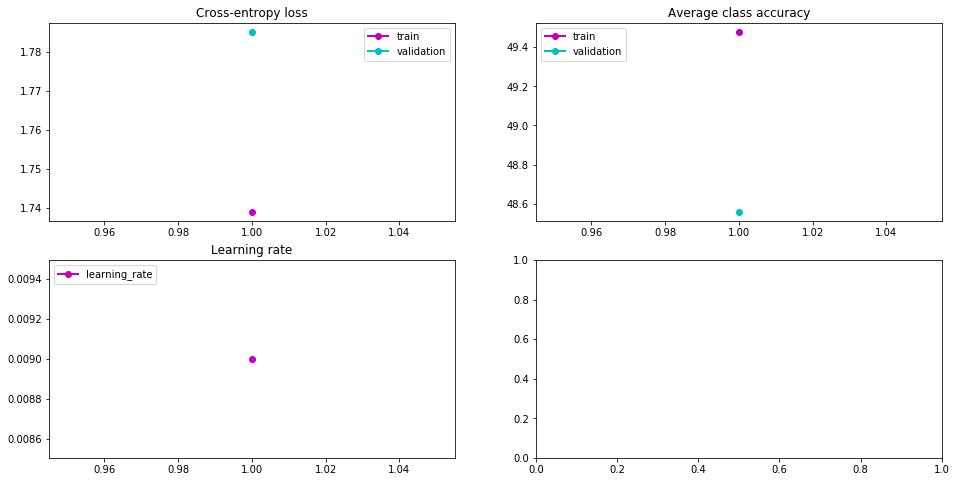

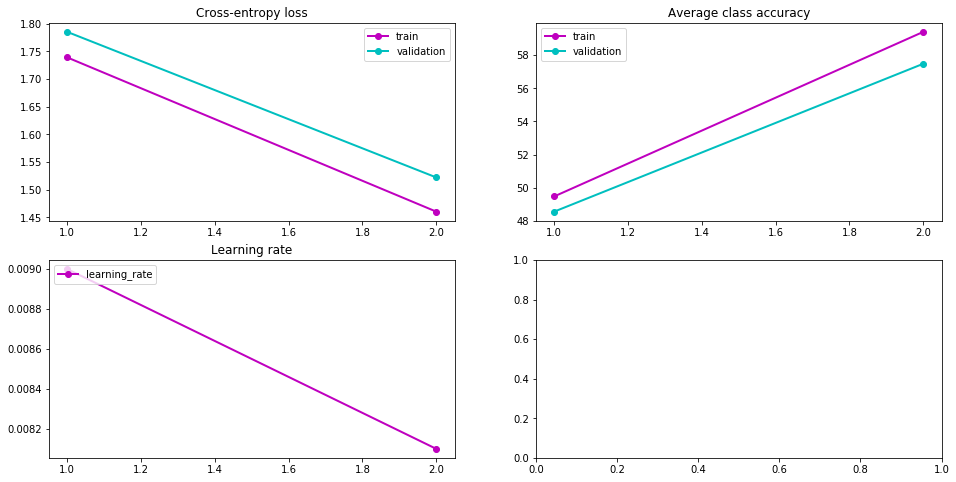

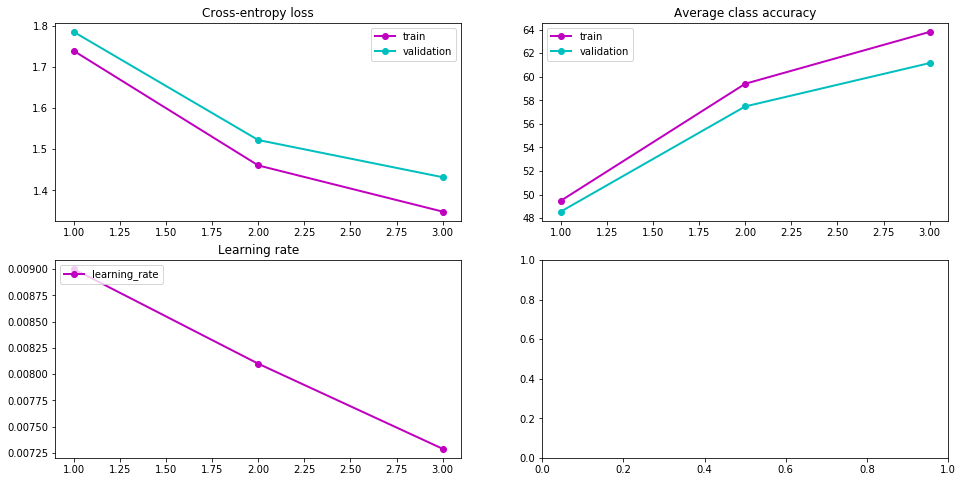

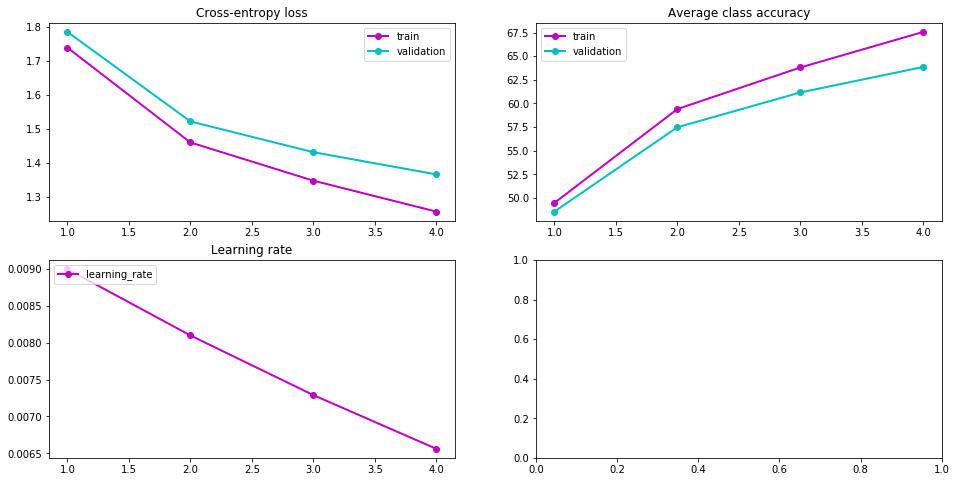

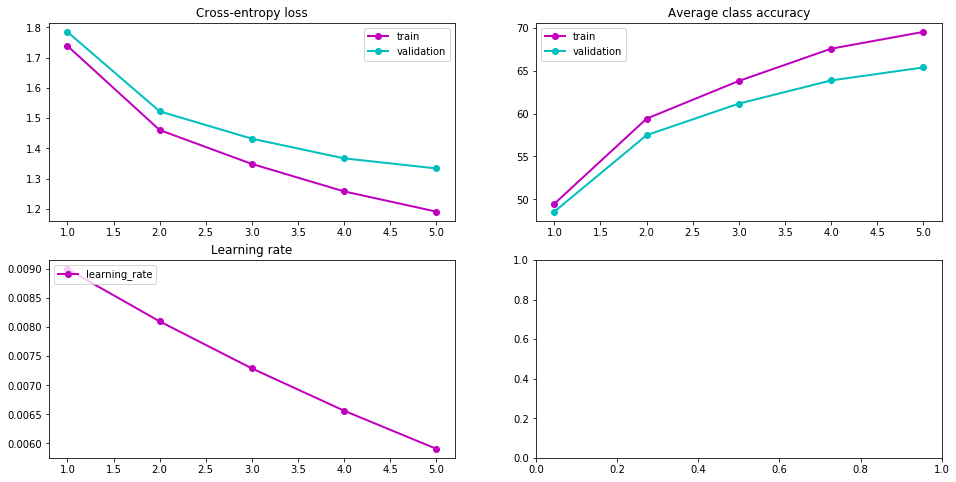

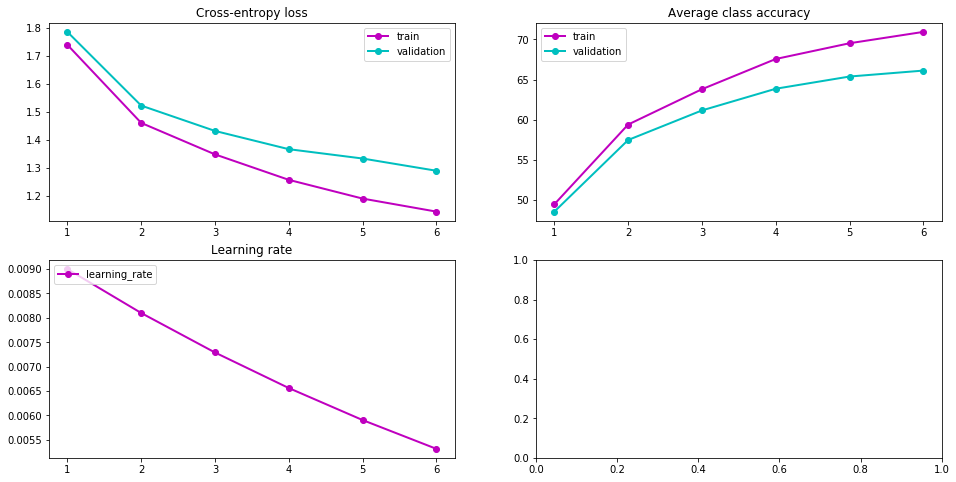

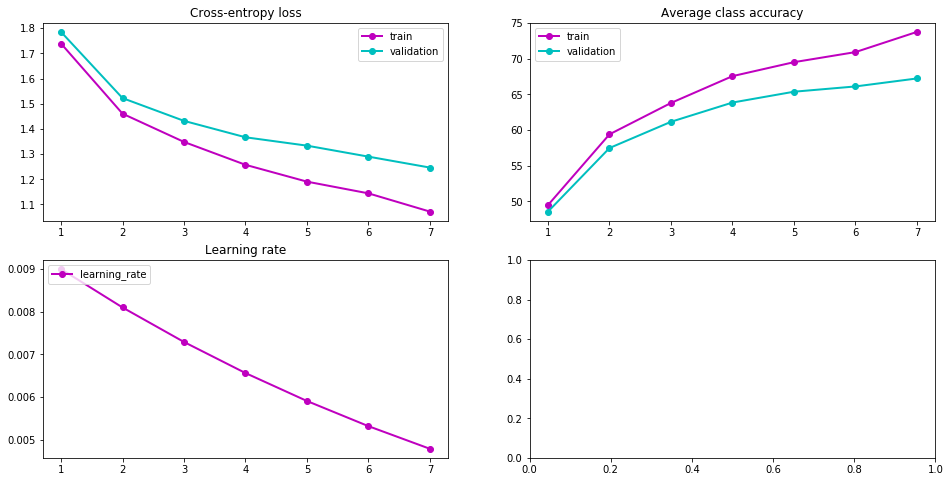

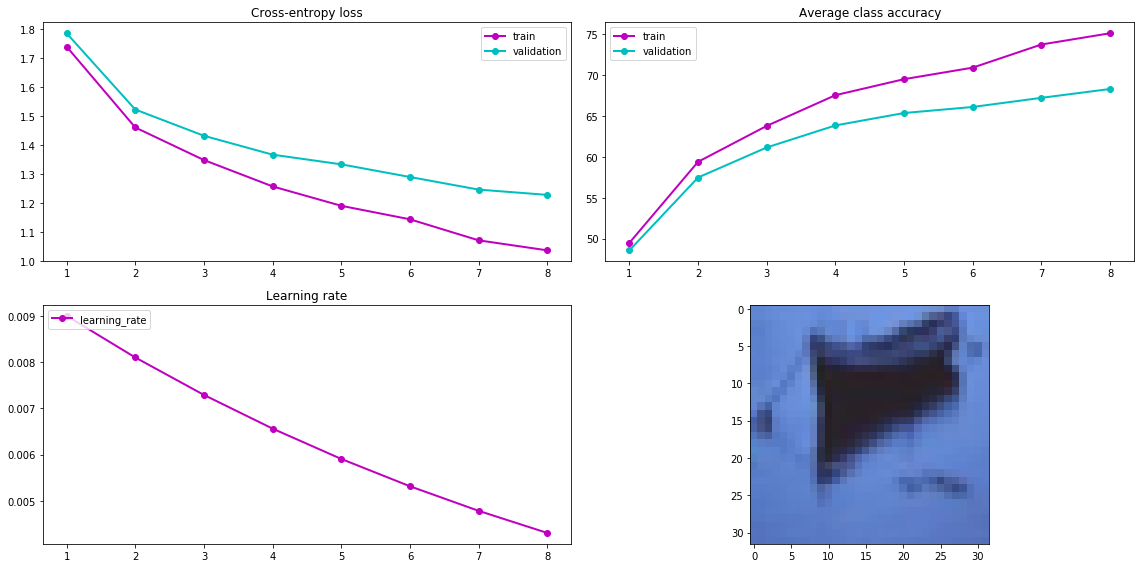

Correct class:
ship

Predicted classes:
airplane 74.2%
bird 20.0%
cat 4.3%




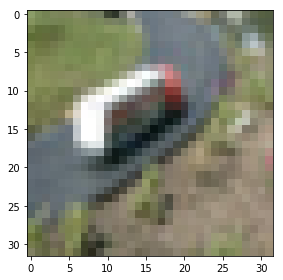

Correct class:
truck

Predicted classes:
bird 95.2%
airplane 3.0%
dog 0.7%




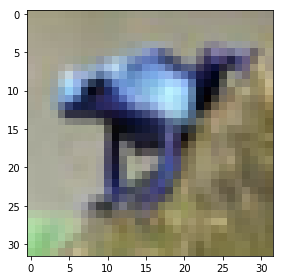

Correct class:
frog

Predicted classes:
horse 47.6%
airplane 26.7%
dog 14.8%




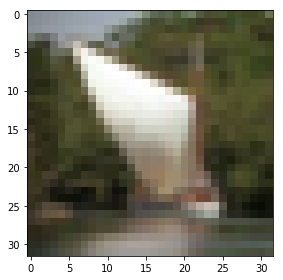

Correct class:
ship

Predicted classes:
bird 49.1%
horse 28.4%
dog 9.7%




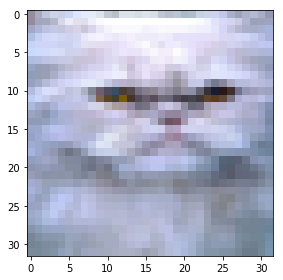

Correct class:
cat

Predicted classes:
airplane 96.8%
ship 2.5%
bird 0.5%




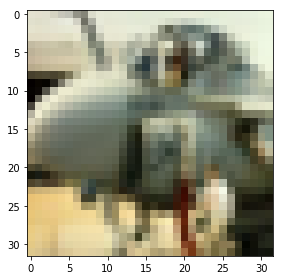

Correct class:
airplane

Predicted classes:
horse 96.3%
cat 1.0%
deer 1.0%




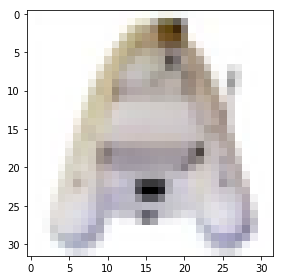

Correct class:
ship

Predicted classes:
frog 90.4%
cat 3.6%
dog 2.4%




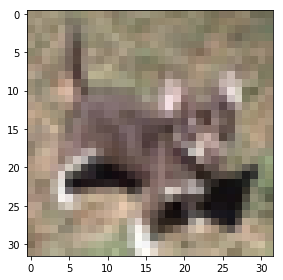

Correct class:
dog

Predicted classes:
frog 98.8%
bird 0.6%
cat 0.2%




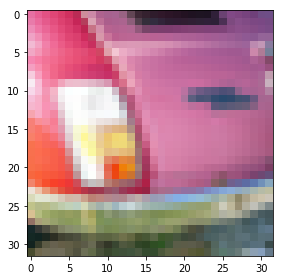

Correct class:
automobile

Predicted classes:
cat 51.3%
dog 22.0%
ship 9.8%




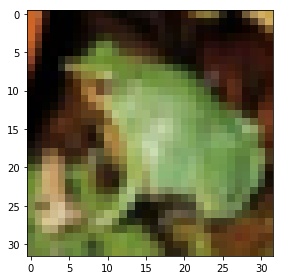

Correct class:
cat

Predicted classes:
frog 99.8%
bird 0.1%
deer 0.1%




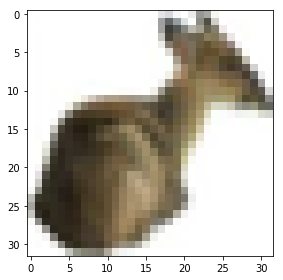

Correct class:
deer

Predicted classes:
cat 84.5%
frog 8.3%
dog 3.4%




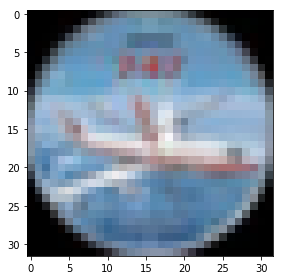

Correct class:
airplane

Predicted classes:
ship 97.3%
automobile 1.0%
cat 0.9%




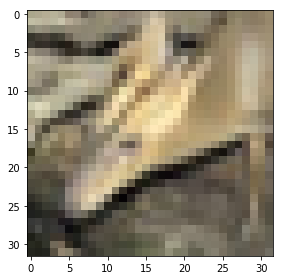

Correct class:
deer

Predicted classes:
frog 94.2%
bird 2.9%
cat 1.7%




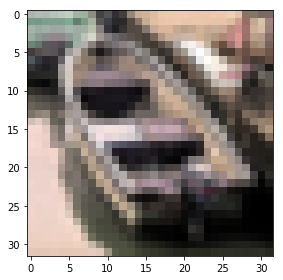

Correct class:
ship

Predicted classes:
automobile 73.3%
frog 7.8%
bird 7.1%




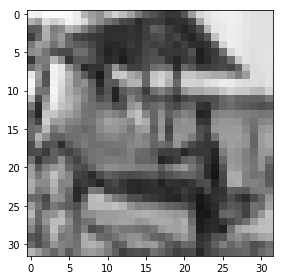

Correct class:
airplane

Predicted classes:
truck 96.2%
horse 1.0%
frog 0.9%




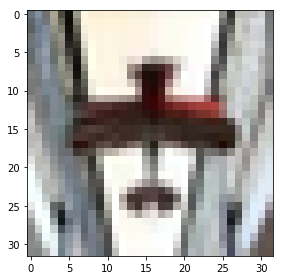

Correct class:
airplane

Predicted classes:
cat 44.5%
horse 39.2%
deer 8.8%




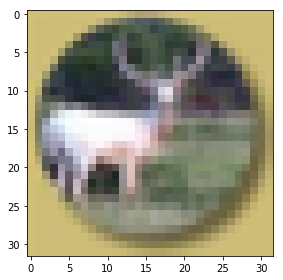

Correct class:
deer

Predicted classes:
automobile 89.3%
truck 5.3%
horse 3.5%




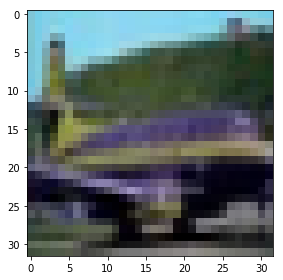

Correct class:
airplane

Predicted classes:
truck 94.1%
automobile 5.6%
ship 0.2%




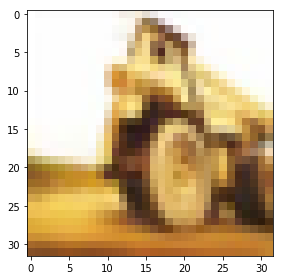

Correct class:
truck

Predicted classes:
horse 40.7%
dog 30.0%
deer 17.4%




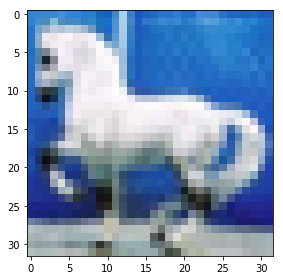

Correct class:
horse

Predicted classes:
airplane 89.1%
ship 3.9%
truck 3.4%




In [15]:
class_names = np.array(unpickle(os.path.join(DATA_DIR, 'batches.meta'))['label_names'])

for sample_id, _, predicted in worst:
    draw_image(test_x[sample_id], data_mean, data_std)
    probs = session.run(tf.nn.softmax(net), feed_dict={X: np.array([test_x[sample_id]])})[0]
    predictions  = np.argsort(-probs)

    print('Correct class:')
    print(class_names[test_y[sample_id]])
    print()
    print('Predicted classes:')
    for i in range(3):
        print('{} {:.1f}%'.format(class_names[predictions[i]], probs[predictions[i]]*100))
    print();print()

If you have access to a GPU, you might want to try obtaining better results with a more powerful model. In that case, [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130) you can find a review of state-of-the-art results on this dataset. As you see, best approaches achieve around 96% overall classification accuracy. Two important tricks to achieve this are image upsampling and jittering. Image upsampling ensures that early convolutions detect very low level features, while jittering prevents overfitting. Without these techniques, it will be very hard for you to achieve more than 90% overall classification accuracy.